# Instagram Network Analysis
What does it mean to follow someone on Instagram?  Instagram does a lot (seemingly too much at times), but for me, Instagram's most important role is as the largest repository of people in my life. I don't really follow meme pages, organizations, celebrities or influencers. For me, following someone on Instagram has a symbolic meaning; each connection represents a distinct interaction or relationship in my life, from lifelong friends to brief encounters.

I wouldn't say that I've established an authentic human connection with all of the nearly 1400 people in my Instagram network. I wouldn't even say I like everyone in the network, but at some point in time, I tapped the blue button on their profile, and they tapped the blue button on mine. So this notebook is a study of the people that have crossed that threshold, and the communities that they form together.

### Objectives
 1. **Understanding Network Structure**: The first objective of this analysis is understanding the *structure* of my Instagram network. It is about identifying the subcommunities in my network, and the communities within those subcommunities. This part of the analysis required by far the most work, including:
    - Developing an entirely new hierarchical graph partitioning algorithm based on Louvain's algorithm, which demonstrably performs better at uncovering the structure of my Instagram network than more widely known hierarchical graph clustering algorithms like Girvan-Newman and Recursive Spectral Bisection.
    - Heavily enhancing visualization libraries like `plotly` and `pyviz` to effectively visualize network structure. 
 
     The two main visuals from this part of the analysis were:
     - [A interactive dendrogram showing the hierarchical breakdown of communities, utilizing my custom algorithm ](https://rbl-dendrogram.netlify.app)
     - [An interactive graph of the network, clustered with Louvain's method](https://louvain-graph.netlify.app)
    
    Ultimately, this part of the analysis offers real insight into how the communities of people in my life are arranged.

 2. **Analyzing Individual Nodes**: I spend some time looking at key node-related metrics with the goal of understanding what attributes make a close friend. Since I have no objective metric of 'closeness', this part of the analysis is less formal and is more about discovering metrics that highlight who I intuitively believe to be the close people in my life.

### Key Terms

##### Nodes
In this analysis, nodes correspond to individual user accounts. Each node is a distinct user that I happen to be following, minus the organizations and influencers that I don't personally know.

##### Edges
Edges are the links between nodes in the network. In this context, an edge indicates a relationship between two users in my network. These connections form the basis for the network's structure, allowing us to visualize and analyze the web of relationships.

##### Graph
A graph is a network of nodes and edges. For example, my Instagram network is a graph, with users as nodes and the connections between users as edges. In this analysis, we're assuming the network is undirected, meaning if Jane follows John, we assume that John follows Jane. Since we've filtered out organizational accounts and influencers, this is a reasonable assumption. Two related terms are:
- *Subgraph*: A subgraph is a subset of nodes in a graph, and the edges that connect them
- *Supergraph*: A supergraph is a graph where each node represents a subgraph. The edges between nodes in a supergraph are weighted by the total number of connections between the constituent nodes in the supergraph nodes

##### Degree
The degree of a node reflects the number of edges (connections) it has in the network. Since this analysis assumes an undirected graph (mutual connections), the degree represents the total number of mutual relationships an account has within my Instagram network. High-degree nodes suggest users that are more deeply embedded in my network.

#### Metrics for Measuring the Quality of a Graph Partition

##### Modularity
Modularity ($ Q $) measures the strength of division of a network into communities, which in this case, are groups of Instagram users who collectively follow each other more than to the rest of the network. A high modularity score suggests a clear delineation of clusters within the network, with dense interconnections within communities and sparser connections between them.

The modularity $ Q $ of a network partition is given by:
$$Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_i k_j}{2m} \right) \delta(c_i, c_j)$$

Where:

- $ A_{ij} $ is 1 if there is a mutual following relationship between user $ i $ and user $ j $, and 0 otherwise.
- $ k_i $ is the degree of user $ i $, representing the number of mutual connections.
- $ m $ is the total number of mutual following relationships in the network, which is the sum of all edges as the graph is undirected.
- $ \delta(c_i, c_j) $ is 1 if users $ i $ and $ j $ are in the same community, and 0 otherwise.

This is basically saying "For all communities, across every distinct pair of nodes in a community, sum whether the nodes are connected (1 for connected, 0 for not) minus the number of expected edges between the two nodes if the connections of the network were distributed randomly." The number of expected edges is approximated by the product of the degrees of the two nodes divided by double the total number of edges in the network. So for two connected nodes, modularity heavily penalizes high-degree nodes that aren't in the same community, and heavily rewards low-degree nodes that are in the same community.

##### Coverage
Coverage is a metric that assesses the extent to which a network's edges are confined within its identified communities. It emphasizes the internal density of community connections.

The coverage ($ C $) of a partition is given by:
$$C = \frac{\text{Number of intra-community edges}}{\text{Total number of edges in the graph}}$$

For our network analysis, this means:

- *Intra-community edges* are the connections where both individuals follow each other, and both belong to the same community.
- *Total number of edges* includes all mutual following relationships in the entire network.

High coverage implies that most of the mutual connections in the network are within communities, suggesting that users have a strong preference for interacting with others within their identified groups.

##### Performance
Performance, on the other hand, measures the accuracy of the community divisions by considering correct and incorrect classifications.

The performance ($ P $) of a partition is expressed as:
$$P = \frac{\text{Number of intra-community edges + Number of inter-community non-edges}}{\text{Total number of potential edges}}$$

In the Instagram network context:

- *Intra-community edges* remain the same as for coverage, indicating mutual followings within the same community.
- *Inter-community non-edges* refer to potential mutual followings that do not exist between members of different communities.
- *Total number of potential edges* is the total number of possible mutual following relationships that could theoretically exist in the network.

High performance implies not only that users within a community follow each other but also that users across different communities do not tend to follow each other.

##### Imports

In [1]:
import networkx as nx
import community as community_louvain
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import webbrowser
import importlib
from constants import PROCESSED_FOLLOWING_PATH, FA2L_POSITIONS_PATH, GN_HIERARCHY_PATH, USERNAME
import sys

original_sys_path = sys.path.copy()
sys.path.append('../')
from insta_graph import graph_visualization
from insta_graph import hierarchical_graph_clustering
from insta_graph.utils import load_ig_network
sys.path = original_sys_path

Loading in network from json file

In [2]:
G = load_ig_network(PROCESSED_FOLLOWING_PATH)

## Exploring Instagram Network Structure

 #### Louvain Partition

The Louvain method is a network clustering technique based on maximizing modularity. The method finds partitions of the network (i.e., communities) such that the modularity $ Q $ is maximized. The process is as follows:

1. **Initialization**: Every node starts as its own community.
2. **Modularity Optimization**: For each node, the change in modularity is calculated when moving the node to different communities. The node is placed in the community with the maximum modularity gain. If no gain is achieved, it remains in its current community. This step is iterated for all nodes until no further increase in modularity is observed.
3. **Community Aggregation**: Based on the communities found in step 2, a new supergraph of the network is formed where each community becomes a single node.
4. **Repetition**: Steps 2 and 3 are repeated on the aggregated network until modularity cannot be further increased.

The objective of the Louvain method is to find a partition where intra-community edges are denser than what would be expected in a random network, and inter-community edges are sparser, thus maximizing the modularity $ Q $.

Getting Louvain Partition

In [3]:
# Compute the best partition using Louvain
louvain_partition = community_louvain.best_partition(G, random_state=42)

#### Determining Partition Layout with Force Atlas 2
We're using `pyvis` for graph visualization, which is built on `vis.js` and includes the `ForceAtlas2` layout algorithm. However, this layout algorithm runs when you open the HTML file, causing a lengthy 10-minute wait each time we want see the Instagram network. To optimize this, we're pre-computing node positions to avoid recalculations each time the HTML is loaded.

The underlying principle of ForceAtlas2 is the simulation of forces:
- Nodes repel each other like magnets (repulsive force).
- Edges act as springs and try to maintain an optimal distance between connected nodes (attractive force).
- An additional gravity force attracts nodes towards the center of the space to ensure a compact layout.

Through the balance of these forces, ForceAtlas2 positions nodes in a manner where densely connected nodes cluster together while ensuring that less connected nodes are pushed farther apart, providing a clear visual insight into the network's structure.

##### Tips on Tuning Parameters
You're going to want to adjust `gravity` and `scaling_ratio` attributes to find the right balance of repulsion and attraction for your given network. I've set `strong_gravity_mode` to `True`, which makes gravity affect further away nodes more than more central nodes, leading to a more compact layout. With this configuration, a rule of thumb is to:
- Increase `gravity` and decrease `scaling_ratio` for more a more compact layout
- Decrease `gravity` and increase `scaling_ratio` for more looser layout

Having more `gravity` will force a more circular layout, so if you want to make your nodes further apart while maintaining the shape of your network you should focus more on increasing `scaling_ratio`

In [4]:
import fa2l
import os
import pickle

if os.path.exists(FA2L_POSITIONS_PATH):
    with open(FA2L_POSITIONS_PATH, 'rb') as file:
        fa2l_positions = pickle.load(file)
else:
    fa2l_positions = fa2l.force_atlas2_layout(G,
                                        iterations=1000,
                                        pos_list=None,
                                        node_masses=None,
                                        outbound_attraction_distribution=False, #experiment
                                        lin_log_mode=False,
                                        prevent_overlapping=False,
                                        edge_weight_influence=1.0,

                                        jitter_tolerance=1.0,
                                        barnes_hut_optimize=True,
                                        barnes_hut_theta=0.5,

                                        scaling_ratio=50.0,
                                        strong_gravity_mode=True,
                                        multithread=False,
                                        gravity=0.15)
    with open(FA2L_POSITIONS_PATH, 'wb') as file:
        pickle.dump(fa2l_positions, file)

In [5]:
# Adjusting orientation for better interprability
fa2l_positions = graph_visualization.rotate_coordinates(fa2l_positions, -90)

### Generating Interactive Visualization with Pyvis

In [6]:
LOUVAIN_PYVIS_PATH = '../visuals/ig_network_louvain_partition.html'
louvain_G = graph_visualization.generate_pyvis_graph(G, fa2l_positions, louvain_partition, LOUVAIN_PYVIS_PATH, cluster_name='louvain_cluster', menus=False, color_seed=21)

There's already a file here. Rename, move, or delete the file before proceeding


In [7]:
LOUVAIN_PYVIS_MENU_PATH = '../visuals/ig_network_louvain_partition_menu.html'
louvain_G = graph_visualization.generate_pyvis_graph(G, fa2l_positions, louvain_partition, LOUVAIN_PYVIS_MENU_PATH, cluster_name='louvain_cluster', menus=True, color_seed=21)

#### [Click Here To Launch Interactive Graph Visual](https://655577051903af1e15d7ab1d--animated-bavarois-8da30a.netlify.app/)

### Interpreting Louvain Partition

<table>
<tr>
    <td>
        <img src="screenshots/louvain_screenshot.png" alt="Louvain Partition" title="Louvain Partition"/>
    </td>
    <td style="vertical-align:top; padding-left:10px;">
        <h3 style="text-align:left;">First Impressions</h3>
        <p>We can see that there are really two main groups in the network: the big glob of nodes on the lefthand side represents the connections that I made growing up in the densely connected suburbia of St. Louis, and the righthand side represents the friends that I've made in the world beyond. If life is the people in it, then the lefthand side largely represents life before turning 18 and the righthand side represents life after leaving the nest.</p><br>
        <p>That being said, I'm surprised that the greek life friends take up such a large space in the network, as I wouldn't say that greek life accounted for half of my college experience. But given the social nature of greek life, it's an incredibly densely connected community, which is why Louvain's algorithm distinguishes it from the rest of my USC friends.</p><br>
        <p>At the outskirts, you can find random groups of people that I've met in my travels, some of whom are entirely disconnected from the rest of my network.</p><br>
        <p>If you look towards the cyan colored group labeled 'study abroad friends', you can see a weakness in the Force Atlas 2 layout approach. Because the community is so small, we can see that the attractive force of each side of the group is unable to overcome the repulsive forces of the to main communities, and the group stays separated. Since the node positions are initialized randomly, it's possible for these situations to happen.</p><br>
    </td>
</tr>
</table>


In [8]:
louvain_cluster_df = hierarchical_graph_clustering.get_cluster_analysis_df(louvain_G, cluster_name='louvain_cluster')

In [9]:
louvain_cluster_labels = friends_dict = {
    0: "Non-greek life college friends",
    2: "High School Friends",
    3: "Elementary School Friends",
    1: "Greek life college friends",
    6: "Study Abroad Madrid Friends",
    22: "Jakarta Internship Coworkers",
    7: "Jakarta Non-Work Friends"
}
louvain_cluster_df['louvain_label'] = louvain_cluster_df['louvain_cluster'].apply(lambda x: louvain_cluster_labels[x] if x in louvain_cluster_labels else x)

In [48]:
louvain_cluster_df =  louvain_cluster_df.sort_values(by='num_nodes', ascending=False)
louvain_cluster_df.head(7)

,louvain_cluster,num_nodes,intra_edges,inter_edges,top_3_connected_nodes,density,louvain_label
0,0,484,8241,4506,"HipHopHummus, EspressoEtude, CharcoalChaser",0.070505,Non-greek life college friends
2,2,455,13993,1146,"FootpathFreiherr, QuayQuartermaster, ReggaeRat...",0.135479,High School Friends
1,1,193,9282,4063,"ManuscriptMarquess, HueHypernova, UrbanUtopia",0.500972,Greek life college friends
3,3,45,448,447,"RovingRhapsody, TerraTwilight, CedarCircuit",0.452525,Elementary School Friends
6,6,25,61,38,"EtiquetteEmpress, HennaHerald, ElectronEmissary",0.203333,Study Abroad Madrid Friends
21,22,12,53,3,"BisonBrio, QuartersQuisling, QuintetQuartermaster",0.803030,Jakarta Internship Coworkers
23,7,12,22,16,"CharmCutter, ZenithZest, XerusXenon",0.333333,Jakarta Non-Work Friends


We can see that of the largest partitions produced by Louvain's algorithm, the smaller communities tend to be more connected. That being said, it's shocking how tightly connected my fraternity community is given it's size of nearly 200 people

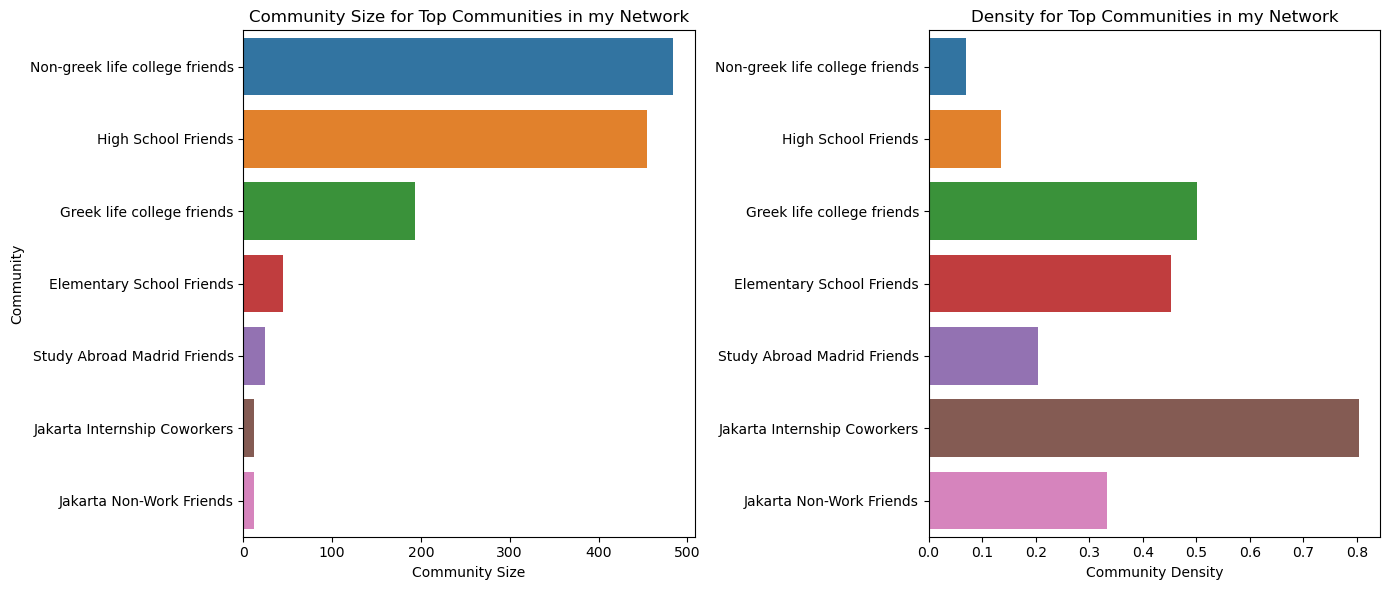

In [11]:
# Set up the matplotlib figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # '1, 2' denotes 1 row, 2 columns of subplots

# First barplot on the left
sns.barplot(data=louvain_cluster_df.head(7), x='num_nodes', y='louvain_label', orient='horizontal', ax=axes[0])
axes[0].set_title('Community Size for Top Communities in my Network')
axes[0].set_xlabel('Community Size')
axes[0].set_ylabel('Community')

# Second barplot on the right
sns.barplot(data=louvain_cluster_df.head(7), x='density', y='louvain_label', orient='horizontal', ax=axes[1])
axes[1].set_title('Density for Top Communities in my Network')
axes[1].set_xlabel('Community Density')
axes[1].set_ylabel('')

# Adjust the layout so that titles and labels don't overlap
plt.tight_layout()

plt.show()

## Hierarchical Cluster Analysis
Louvain's method optimizes for modularity, and while modularity is probably the most widely recognized metric for evaluating a partition, a disadvantage of prioritizing modularity above everything is that if a large community is sufficiently dense, we won't be able to identify sub-communities. Let's take my college community for an example. Louvain's method separates the community into greek life and non greek life, but within the non-greek life community there many subcommunities. There are the various clubs I was a part of, there are people from my freshman year dorm, and there are friends from the different international programs that I was a part of. Even clubs could ostensibly be divided further into the people who were active in the club when I was an underclassman and the people who were active when I was an upperclassman. Looking at the pyvis visual, it's clear to me that the groups can be broken down further. And if I can cluster this network hierarchically, then I'll have succeeded in creating a sort of taxonomy of the people in my life, a single map that captures the nations and states and cities of the people in my world.

### Using Louvain To Produce our Hierarchy
  Since Louvain is an agglomerative clustering method, meaning it starts with smaller clusters and combines them into bigger clusters, we may be able to look at the final result of the algorithm to understand the high level community structure and then progressively examine earlier iterations to reveal nested sub-communities within those larger groups.

We'll try to accomplish this using the `generate_dendrogram` function in `community_louvain` which outputs the groupings at each iteration of Louvain's method. Let's have a look at the first iteration:

In [12]:
FIRST_ITER_FILEPATH = '../visuals/louvain_first_iter.html'
louvain_first_iter = community_louvain.generate_dendrogram(louvain_G, random_state=42)[0]
louvain_first_iter_G = graph_visualization.generate_pyvis_graph(louvain_G,
                                                                positions=fa2l_positions,
                                                                partition=louvain_first_iter,
                                                                cluster_name='louvain_first_iter',
                                                                output_filepath=FIRST_ITER_FILEPATH,
                                                                color_seed=111)

There's already a file here. Rename, move, or delete the file before proceeding


#### [Click Here to See Interactive Visual of First Louvain Iteration](https://louvain-first-iteration.netlify.app/)

In [14]:
hierarchical_graph_clustering.get_cluster_analysis_df(louvain_first_iter_G, 'louvain_first_iter').head()

,louvain_first_iter,num_nodes,intra_edges,inter_edges,top_3_connected_nodes,density
0,21,99,782,1480,"KnotsmanKnight, PlunderingProducer, HipHopHerb",0.161204
1,7,370,6671,4530,"HipHopHummus, EspressoEtude, CharcoalChaser",0.097722
2,24,193,9282,4063,"ManuscriptMarquess, HueHypernova, UrbanUtopia",0.500972
3,8,330,10988,2608,"FootpathFreiherr, QuayQuartermaster, ReggaeRat...",0.202413
4,34,52,465,905,"HipHopHalibut, InkwellImpulse, PinnaclePeak",0.350679


The problem with using this approach for hierarchical clustering is that in a network as densely connected as ours, the first iteration of Louvain's algorithm produces clusters that don't capture the nuanced substructures within communities. To illustrate, let's filter down to the non-greek-life college group identified by the first Louvain iteration and see if we can identify any subgroups:

<img src="screenshots/louvain_first_iter.png" alt="Louvain Partition" title="Louvain Partition" width="80%"/>

We can see that the first iteration of Louvain's algorithm doesn't capture the level of granularity that I can identify myself. We can increase the `resolution` parameter in `generate_dendrogram` to get more initial groupings, but in the case of my network, this never yields more than two iterations:

In [15]:
normal_rez = community_louvain.generate_dendrogram(louvain_G, random_state=42, resolution=1)
high_rez = community_louvain.generate_dendrogram(louvain_G, random_state=42, resolution=5)
print(f"Number of initial groups with normal resolution: {max([v for k, v in normal_rez[0].items()])},\t Number of iterations: {len(normal_rez)}")
print(f"Number of initial groups with high resolution: {max([v for k, v in high_rez[0].items()])},\t Number of iterations: {len(high_rez)}")

Number of initial groups with normal resolution: 37,	 Number of iterations: 3
Number of initial groups with high resolution: 137,	 Number of iterations: 2


In other words, even though we can start with really granular groups using Louvain's algorithm, Louvain's algorithm doesn't offer a good account of how the original graph can be divided again and again to get to those groups. We don't just want two levels of granularity, we want a full breakdown of how the community decomposes into smaller and smaller subgroups, and if we want to visualize this using a dendrogram, we need this breakdown split by split. To get that we need to turn to different techniques:

### Girvan-Newman Algorithm

The Girvan-Newman algorithm is a popular method used in network analysis to detect communities within a network. The algorithm operates on the principle of betweenness centrality, which is a measure of the number of shortest paths that pass through a given edge in a network. Here's how the algorithm unfolds step by step:

1. **Calculate Betweenness Centrality:** For every edge in the network, calculate the betweenness centrality. This identifies the most 'central' edges in the network, which are often the ones that connect different communities.
2. **Remove Edges:** Identify the edge with the highest betweenness centrality and remove it from the network. This is based on the idea that these edges are likely the 'bridges' between communities.
3. **Recalculate Centrality:** After removing the edge, betweenness centrality scores need to be recalculated for all remaining edges, as they may have changed due to the alteration in network structure.
4. **Iterate:** Repeat the process of removing edges and recalculating centralities until no edges remain, or until the desired number of communities is achieved.
5. **Build Communities:** As edges are removed, the network will eventually break into separate components. Each of these components represents a community.

The Girvan-Newman algorithm has a high computational complexity, primarily due to the repeated calculation of betweenness centrality for every edge in the network. Specifically, the complexity can be as high as $ O(n \cdot m^2) $ for sparse networks and $ O(n^3) $ for dense networks, where $ n $ is the number of nodes and $ m $ is the number of edges. In my network of around 1,400 people and 38,000 connections, this resulted in a computation time of about a day.

In [16]:
# Load in Graph with our username, so that the graph is fully connected
G = load_ig_network(PROCESSED_FOLLOWING_PATH, include_your_username=USERNAME)

In [17]:
# Load girvan_newman hierarchy
assert os.path.exists(GN_HIERARCHY_PATH), "Load Girvan-Newman Hierarchy First"
with open(GN_HIERARCHY_PATH, 'rb') as file:
    gn_hierarchy = pickle.load(file)

In [18]:
gn_partitions_filepath = '../data/processed/gn_partitions.analysis.parquet'
if os.path.exists(gn_partitions_filepath):
    gn_partitions_analysis_df = pd.read_parquet(gn_partitions_filepath)
else:
    gn_partitions_analysis_df = hierarchical_graph_clustering.get_hierarchical_cluster_analysis_df(G, gn_hierarchy)
    gn_partitions_analysis_df.to_parquet('../data/processed/gn_partitions.analysis.parquet')

Text(0.5, 1.0, 'Partition performance metrics by number of partitions')

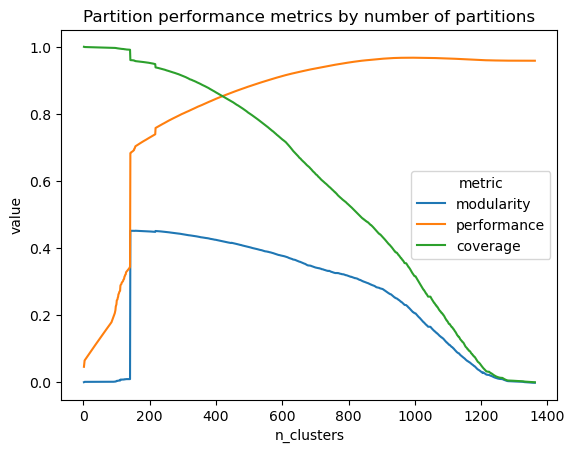

In [19]:
# Reshape the DataFrame
melted_df = pd.melt(gn_partitions_analysis_df, id_vars=['n_clusters'], value_vars=['modularity', 'performance', 'coverage'], var_name='metric', value_name='value')
sns.lineplot(data=melted_df, x='n_clusters', y='value', hue='metric')
plt.title('Partition performance metrics by number of partitions')

We can see here that Girvan newman doesn't result in a usable partition in terms of performance or modularity until around 140 partitions in, which means Girvan-Newman won't be useful for us in determining the hierarchical structure of our communities, and would be nearly impossible to visualize with a dendrogram. This is disappointing given the incredibly long compute time of the algorithm.

<Axes: xlabel='n_clusters', ylabel='value'>

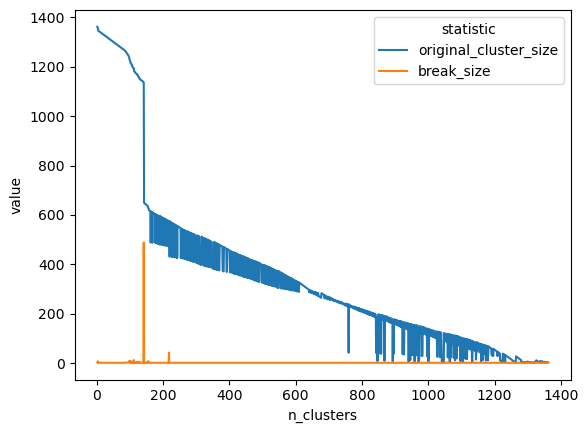

In [20]:
melted_partition_data = gn_partitions_analysis_df.melt(id_vars='n_clusters', value_vars=['original_cluster_size', 'break_size'], var_name='statistic', value_name='value')
sns.lineplot(melted_partition_data, x='n_clusters', y='value', hue='statistic')

Above it's clear that most of the partitions in Girvan-Newman result from one-off breaks, and that in practice the algorithm did more whittling away at the periphery of each cluster rather than splitting communities into distinguishable subgroups. The reason it looks like the original cluster size line is thick in the middle is that the small partitions are alternating between one huge cluster and another. This is after the biggest cluster is broken in two at n_clusters = 142

In [21]:
gn_partitions_analysis_df.iloc[135:145]

,n_clusters,modularity,coverage,performance,q1_cluster_size,median_cluster_size,q3_cluster_size,min_cluster_size,max_cluster_size,original_cluster_size,break_size,len_gini_coefficient,change_in_modularity,change_in_performance,change_in_coverage
135,137,0.009298,0.991473,0.337714,1.0,1.0,1.0,1,1142,1143,1,0.442228,-6.962694e-07,0.001226,-0.000078
136,138,0.009297,0.991421,0.338941,1.0,1.0,1.0,1,1141,1142,1,0.441917,-4.655231e-07,0.001227,-0.000052
137,139,0.009296,0.991343,0.340164,1.0,1.0,1.0,1,1140,1141,1,0.441606,-7.013075e-07,0.001224,-0.000078
138,140,0.009346,0.991188,0.342607,1.0,1.0,1.0,1,1138,1140,2,0.441126,4.994465e-05,0.002443,-0.000156
139,141,0.009346,0.991110,0.343827,1.0,1.0,1.0,1,1137,1138,1,0.440815,-7.123914e-07,0.001220,-0.000078
140,142,0.451475,0.960319,0.682975,1.0,1.0,1.0,1,649,1137,488,0.437545,4.421290e-01,0.339148,-0.030791
141,143,0.451453,0.960267,0.683670,1.0,1.0,1.0,1,648,649,1,0.437253,-2.124478e-05,0.000695,-0.000052
142,144,0.451410,0.960086,0.685048,1.0,1.0,1.0,1,646,648,2,0.436786,-4.379242e-05,0.001379,-0.000181
143,145,0.451367,0.959982,0.685736,1.0,1.0,1.0,1,645,646,1,0.436493,-4.250703e-05,0.000687,-0.000104
144,146,0.451335,0.959905,0.686424,1.0,1.0,1.0,1,644,645,1,0.436199,-3.188330e-05,0.000688,-0.000078


Exploring the split size for each partition reveals that there are only a handful of breaks that result in a new community of a considerable size. Ultimately, we can conclude that Girvan-Newman's algorithm doesn't offer much insight into the hierarchical structure of our communities that we didn't know already

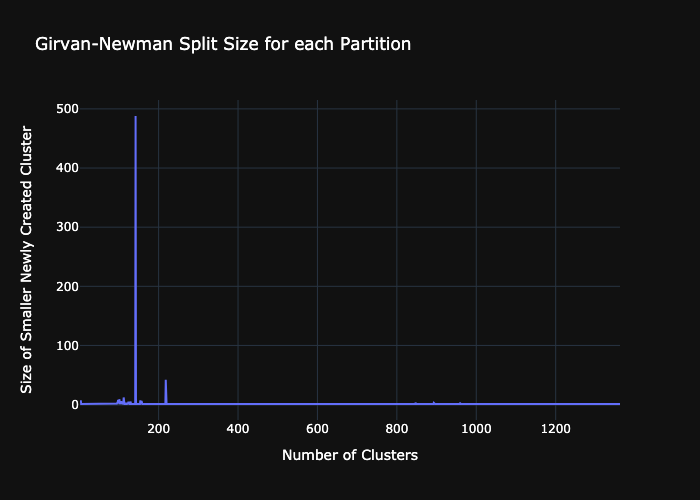

In [46]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Setting the default theme to 'plotly_dark'
pio.templates.default = "plotly_dark"

# Create line plot
fig = go.Figure(data=go.Scatter(x=gn_partitions_analysis_df['n_clusters'], y=gn_partitions_analysis_df['break_size'], mode='lines'))

fig.update_layout(
    title="Girvan-Newman Split Size for each Partition",
    xaxis_title="Number of Clusters",
    yaxis_title="Size of Smaller Newly Created Cluster",
    font=dict(
        size=12,
        color="#FFFFFF"
    )
)
fig.show()

### Recursive Spectral Bisection
Given the dissappointing results from the Girvan-Newman partition, I had to turn to other techniques for to decompose my Instagram network hierarchically. One straightforward method is recursive spectral bisection (RSB), which is grounded in algebraic graph theory. This approach taps into the mathematical properties of my network's structure by examining the Laplacian matrix — a representation that embodies the network's connectivity.

Here's a distilled explanation of spectral bisection:

Spectral Bisection: The algorithm begins by computing the Laplacian of the network, which is defined by $L = D - A$ where $D$ is the degree matrix, a diagonal matrix where each diagonal element $D_{ii}$ is the degree of node $i$, and where $A$ is the adjacency matrix. It then finds a the Fiedler vector, which corresponds to the second-smallest eigenvalue of this matrix. The signs of the components of this vector suggest a natural way to divide the network into two communities.

Recursive Application: After the initial bisection, the algorithm generates subgraphs of each newly formed community and applies the same spectral bisection method to each, further dividing them into smaller, more densely connected groups. This process is repeated, prioritizing the largest communities first, until each remaining group is smaller than the inputted community size threshold

In [23]:
rsb_hierarchy = hierarchical_graph_clustering.recursive_spectral_bisection(G, community_size_threshold=8)

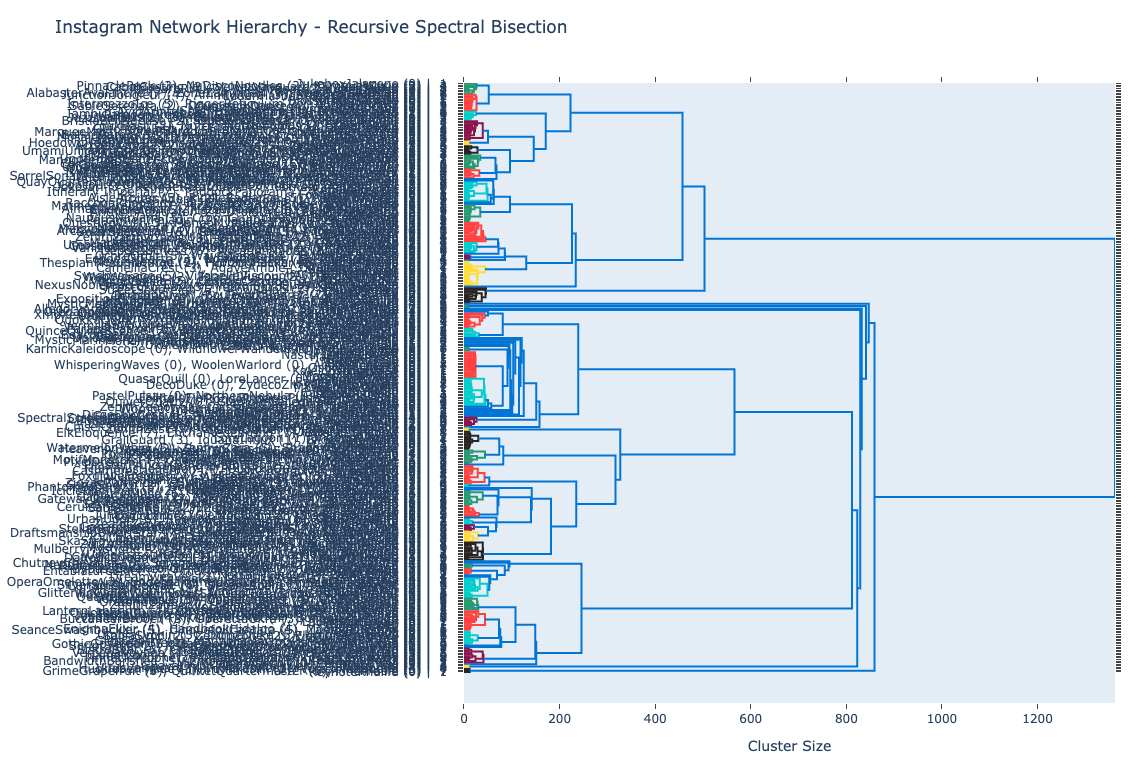

In [50]:
graph_visualization.generate_graph_dendrogram(rsb_hierarchy,
                                              G, visual_filepath='../visuals/rsb_dendrogram.html',
                                              p=100,
                                              color_threshold=50,
                                              width=1200,
                                              title="Instagram Network Hierarchy - Recursive Spectral Bisection",
                                              show=False)

RSB suffers from Girvan-Newman's problem of small clusters splitting off of big clusters which results in a dendrogram that's quite difficult to interpret. Zooming in towards the smaller communities, you can see that many of the subtrees are not well-balanced, indicating that the issue of individuals splintering off from groups exists at every level of this dendrogram.

In [25]:
rsb_partitions_analysis_df = hierarchical_graph_clustering.get_hierarchical_cluster_analysis_df(G, rsb_hierarchy[1:])

100%|██████████| 377/377 [00:14<00:00, 26.43it/s]


### Recursive Louvain Bisection

Given that these two popular methods were producing unsatisfactory results, I had to come up with other techniques. Given that Louvain's method was producing interpretable, well balanced partitions, I wanted to try to apply Louvain's method hierarchically. My first attempt was an algorithm I'll call Recursive Louvain Bisection (RLB). 

Here’s a step-by-step breakdown of RLB:

1. **Initial Louvain Application**: Start by running the Louvain algorithm on the entire network to identify communities. Isolate the community that gives the highest modularity gain.

2. **Subgraph Selection**: For each community that's larger than our set size threshold, apply the Louvain algorithm to that community's subgraph.

3. **Best Modularity Split**: Within these communities, identify the split that offers the most substantial increase in modularity.

4. **Recursive Division**: Continuously repeat the process for every community larger than the threshold, each time executing the split that maximizes modularity.

The procedure ends when all communities are smaller than the threshold or no further modularity gains can be made. Through RLB, we get a hierarchy of communities, finely tuned by the principles of the Louvain method but at a resolution the original algorithm doesn't reach by itself.

In [26]:
rlb_hierarchy = hierarchical_graph_clustering.bisecting_louvain_decomposition(G, community_size_threshold=8)

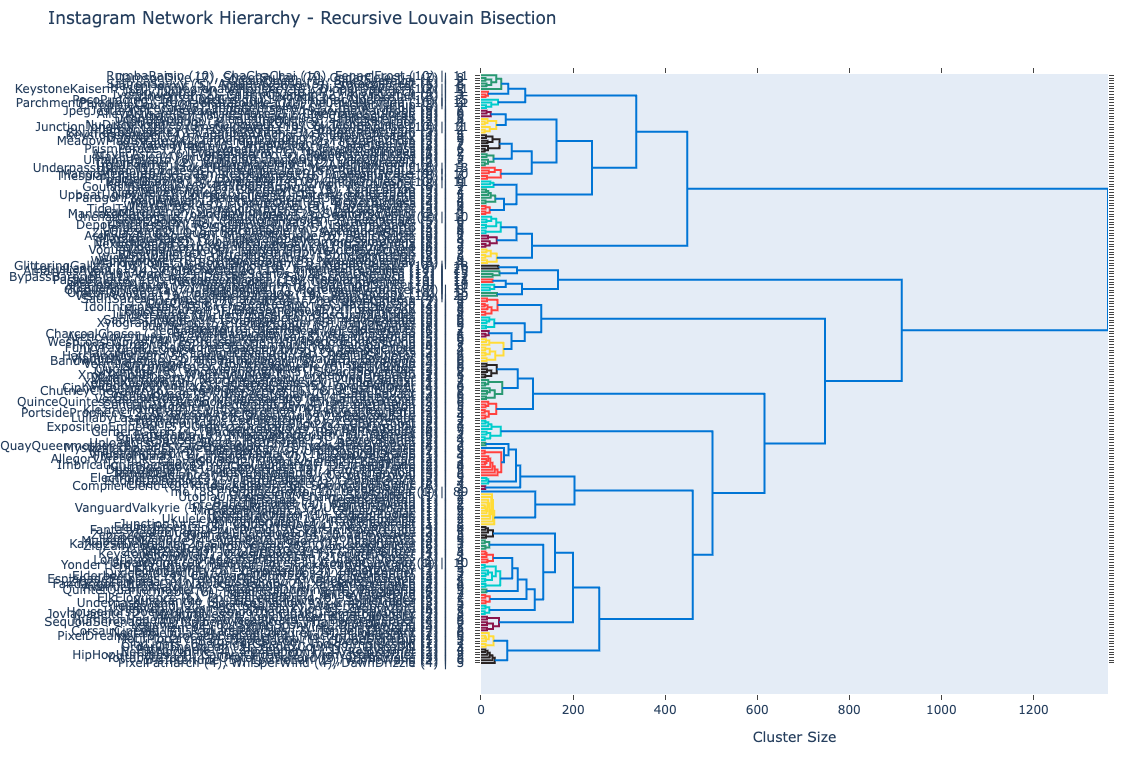

In [51]:
graph_visualization.generate_graph_dendrogram(rlb_hierarchy,
                                              G,
                                              visual_filepath='../visuals/rlb_dendrogram.html',
                                              p=100, color_threshold=50,
                                              width=1200,
                                              title="Instagram Network Hierarchy - Recursive Louvain Bisection",
                                              show=False)

If we computationally couldn't construct a dendrogram using Girvan-Newman, and if Recursive Spectral Bisection produced a dendrogram that was difficult to read, then Recursive Louvain Bisection is a big step in the right direction. The dendrogram is interpretable and when I look at how the clustering is done at the higher levels, everything makes sense.

The core problem with RLB is that the trees in the resulting dendrogram are wildly unbalanced. You can see this in the sort of cascading step-like structure of many of the subtrees, and the result of this is that two communities that are closely related might be arranged far apart from one another. Another consequence of this is that the further down the steps you go, the more seemingly unrelated subcommunities are grouped together.

What's going on under the hood is the algorithm only separates one individual Louvain cluster at a time. So after a while, all of distinct communities are filtered out and we are left with a bunch of largely unrelated groups of people. 

In [28]:
rlb_partitions_analysis_df = hierarchical_graph_clustering.get_hierarchical_cluster_analysis_df(G, rlb_hierarchy[1:])

100%|██████████| 216/216 [00:07<00:00, 27.54it/s]


### Recursive Balanced Louvain

The partitions produced by Louvain's algorithm are inherently pretty balanced. To preserve the integrity of the original Louvain partitioning, I introduced a novel approach called Recursive Balanced Louvain (RBL). This technique iterates upon the Recursive Louvain Bisection by maintaining the structure of the initial Louvain groups throughout the process, thus ensuring a balanced and cohesive decomposition of the network.

Here's a simplified explanation of how RBL works:

1. **Initial Louvain Partitioning**: Apply the Louvain algorithm to the entire network to determine the primary community groupings that maximize modularity.

2. **Recursive Supergroup Bisection**: Examine the entire network as a composition of the identified Louvain groups (supergroups). Calculate how the original network can be iteratively bisected down into these Louvain groups, with each bisection maximizing modularity. 

3. **Apply Steps 1&2 to Recursively to Original Louvain Partitions**: Reapply the Louvain algorithm within each original Louvain partition, determining the best internal structure that maximizes modularity. Decompose the subgraph according to these new partitions. Implement the above steps recursively, ensuring that each subgraph is decomposed in a way that honors the original Louvain structure and optimizes modularity until all communities are within the size threshold.

Here's an illustration of the algorithm:

<img src="screenshots/recursive_balanced_louvain.png" alt="Louvain Partition" title="Louvain Partition" width="1200"/>

The RBL approach works because it harnesses the power of Louvain's algorithm. Unlike RLB, it doesn't alter the partitions proposed by Louvain's method. It simply connects the dots between how the original graph or subgraph can be broken down into the Louvain partitions, split by split, in a way that can be visualized by a dendrogram. 

In [29]:
RBL_HIERARCHY_PATH = '../data/processed/rbl_hierarchy.pickle'
if os.path.exists(RBL_HIERARCHY_PATH):
    with open(RBL_HIERARCHY_PATH, 'rb') as file:
        rbl_hierarchy = pickle.load(file)
else:
    rbl_hierarchy = hierarchical_graph_clustering.balanced_louvain_decomposition(G, community_size_threshold=8)
    with open(RBL_HIERARCHY_PATH, 'wb') as file:
        pickle.dump(rbl_hierarchy, file)

In [30]:
# Labeling Identifiable Clusters
with open("../data/processed/rbl_dendrogram_labels.pkl", "rb") as file:
    dendro_cluster_labels = pickle.load(file)
print(f"# of Labeled Clusters: {len(dendro_cluster_labels.items())}")

# of Labeled Clusters: 64


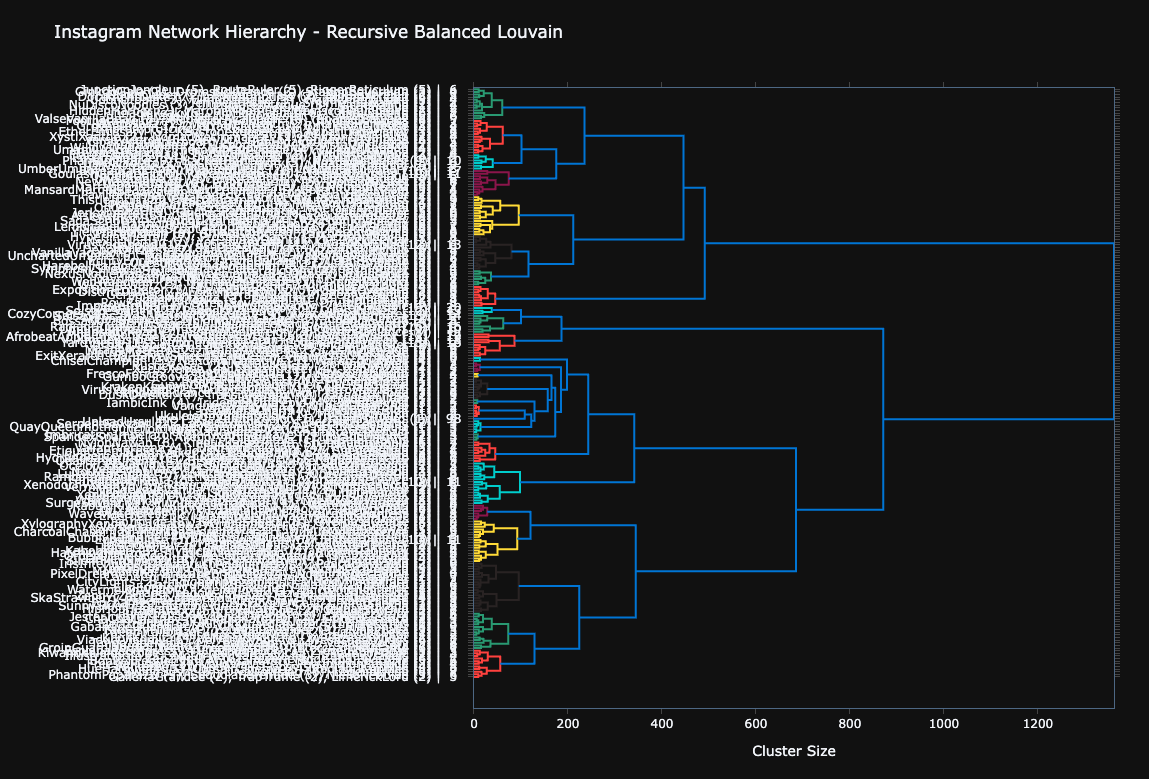

In [54]:
graph_visualization.generate_graph_dendrogram(rbl_hierarchy,
                                              G, visual_filepath='../visuals/rbl_dendrogram.html',
                                              p=100,
                                              color_threshold=100,
                                              cluster_labels_dict=dendro_cluster_labels,
                                              width=1000,
                                              title="Instagram Network Hierarchy - Recursive Balanced Louvain",
                                              show=True)

##### Using Plotly Dendrogram
- The cloud of white text to the left of the visual are actually labels of each 'leaf' cluster.  The labels contain the three most connected users in each leaf cluster, as well as how many people they are connected to. The number all the way to the right is the amount of people in the leaf cluster.
- You can only clearly see these labels if you zoom into a subtree in the dendrogram
- When in zoom mode (default mode) click and drag to highlight a selection to zoom in on it
- To reset the view, click the autoscale icon to at the top right of the visual (to the left of the home icon)

##### [Click Here to Launch Interactive Recursive Balanced Louvain Dendrogram](https://rbl-dendrogram.netlify.app/)

<table>
    <tr>
        <td style="vertical-align:top; padding-left:10px;">
            <h3 style="text-align:left;">Network Structure Analysis</h3>
            <p>The following points jumped out at me when examining the hierarchical network structure produced by
                Recursive Balanced Louvain</p><br>
            <p><b>1.) First Saint Louis Division Between Private and Public Schools:</b> Something that immediately
                jumped out at me when examining the network structure is that the first partition within my high school
                friend network is between Parkway West, a public high school where a lot of my elementary school friends
                ended up going, and the private high schools in the city. I expected the first division to be between people from
                my high school and everyone, else but this division took precedent. Maybe 'phase of life'
                is a key determinant in community formation, but likely what is happening is that there's a broader
                division between the public school spheres and private school spheres among Saint Louis high schools,
                even if these schools are in the same area.</p><br>
            <p><b>2.) Division Between Coed and Single-Sex Private Schools:</b> In the private school cluster, the first
                division is expectecdly between my high school and everyone else. What is interesting is that other
                private schools are then divided among single-sex and coed schools. It makes sense when you think about
                it; I went to an all-boys school and, as much fun as it is hanging out with the boys, there's an
                imperative for students at single-sex schools to rely on other single-sex schools for a full social
                life. This, in turn, would make the entire single-sex school community more intertwined. We would
                imagine that coed schools would be more self-contained communities, and thus be grouped separately.</p>
            <br>
            <p><b>3.) Fraternity Separated from Rest of Post-High School Friends</b> It's interesting that the first
                division of people after college is between my fraternity given that I thought there were a lot of
                friends in my fraternity that were well integrated in some of my other college communities. That being
                said, given the sheer density of connections within my fraternity community it's understandable that
                this group is separated from everyone else.</p><br>
        </td>
        <td width="60%">
            <img src="screenshots/rbl_analysis.png" width="100%">
        </td>
    </tr>
    <tr>
        <td colspan="2" style="vertical-align:top; padding-left:10px;">
            <p><b>4.) Friends Made from International Experiences Very Splintered:</b> You can tell that Recursive Balanced Louvain
                algorithm works because when you look at groups that should be arranged hierarchically, such as those from high
                school or college, they look like balanced trees. In contrast, all of the random groups of people that I've met in my travels are grouped
                together in a mess of branches in the center that stands out from the rest of the dendrogram. It's interesting that
                all of these disconnected groups were grouped together in the first place; they are likely all that's left over after the more densely connected groups are filtered out. Regardless, it's beneficial that they don't clutter the rest of the groupings. One notable point about the international experiences is that a freshman year trip
                to Argentina called LInC is located elsewhere in my USC cluster. It makes sense that this is the case, as this trip
                happened very early in my college career and I became so close with the people I met on that trip that we integrated each other in the rest of our social lives. The resulting cluster of people associated LInC is a lot bigger and broader than just the people that went on the trip, and is more tightly connected with other groups of college friends than my other international experiences.
                rest of my USC network than the people from other international experiences.</p><br>
            <p>If you zoom into the mess of people I've met in my travels, you'll be able to find a leaf cluster with me in it and 98 other people that have never met each other. There's a good reason for this; those random people are what is left after everyone else has found a community, but I think there's something poetic about it. Among my family and best friends, we're grouped with the would-be strangers, the people on the periphery of my life. And if they ran a similar analysis, they would be grouped with me. For a lot of people in my network, meeting them was inevitable given the communities I'm in and the people I'm friends with, but most of these people I met through pure chance, and added on Instagram because I elected to do so. So this is a reminder to not forget about your community of strangers, because maybe deep down they represent us more than any other group we're in.</p><br>
        </td>
    </tr>
</table>


In [34]:
rbl_partitions_analysis_df = hierarchical_graph_clustering.get_hierarchical_cluster_analysis_df(G, rbl_hierarchy[1:])

100%|██████████| 215/215 [00:07<00:00, 28.04it/s]


### Comparative Analysis
Let's take a moment to compare the different hierarchical clustering methods and quantify the strengths and weaknesses of each

In [35]:
gn_partitions_analysis_df['method'] = 'girvan_newman'
rsb_partitions_analysis_df['method'] = 'recursive_spectral_bisection'
rlb_partitions_analysis_df['method'] = 'recursive_louvain_bisection'
rbl_partitions_analysis_df['method'] = 'recursive_balanced_louvain'
all_partition_methods_analysis_df = pd.concat([gn_partitions_analysis_df, rsb_partitions_analysis_df, rlb_partitions_analysis_df, rbl_partitions_analysis_df])

#### Looking at Inequality of Cluster Sizes Across Each Method
The Gini coefficient, originally developed as a measure of income inequality, is a statistical tool that quantifies the distribution of a resource or attribute among a population. It ranges from 0 to 1, where 0 represents perfect equality (every individual has the same amount) and 1 indicates maximum inequality (all the resource is held by a single individual). This concept, although primarily associated with economic studies, is versatile and can be applied to various other forms of inequality. Here I'm using Gini index to look at the inequality of cluster sizes produced by the different methods. Methods that produce clusters with low Gini indexes can be said to be more balanced and thus more useful for our analysis

Text(0, 0.5, 'Gini Coefficient of Cluster Sizes')

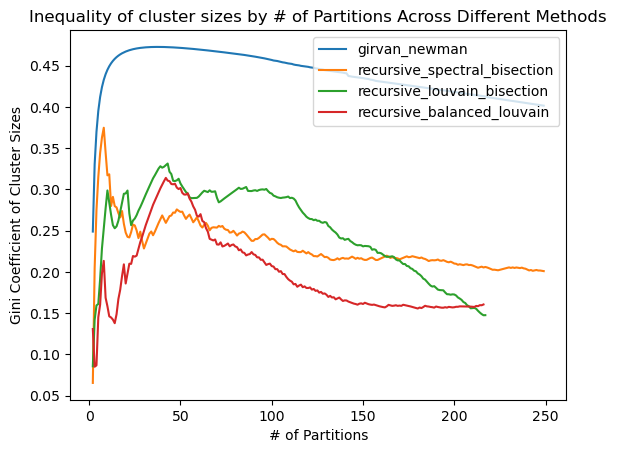

In [36]:
ax = sns.lineplot(
    data=all_partition_methods_analysis_df.query("n_clusters < 250"),
    x='n_clusters',
    y='len_gini_coefficient',
    hue='method'
)
plt.legend(loc='upper right')
plt.title('Inequality of cluster sizes by # of Partitions Across Different Methods')
plt.xlabel('# of Partitions')
plt.ylabel('Gini Coefficient of Cluster Sizes')

Recursive Balanced Louvain produces partitions with more egalitarian cluster sizes than the other methods, indicating that it is a more useful method for looking at the hierarchical structure of graph clusters. When comparing the dendrogram of Recursive Balanced Louvain to other methods, we can see that the branches are generally pretty evenly distributed, while the other methods produce messy, boxy dendrograms that are more difficult to interpret:

<br><img src="screenshots/decomposition_comparison.png" width="1400">


#### Looking at Modularity Across Each Method

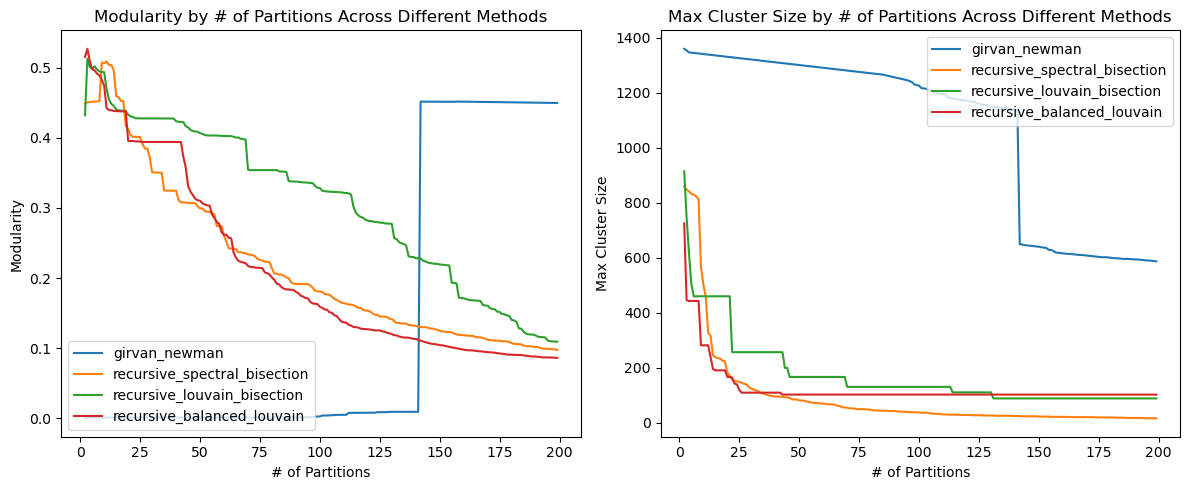

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed

sns.lineplot(
    data=all_partition_methods_analysis_df.query("n_clusters < 200"),
    x='n_clusters',
    y='modularity',
    hue='method',
    ax=axes[0]  # This specifies the subplot to use
)
axes[0].legend(loc='lower left')
axes[0].set_title('Modularity by # of Partitions Across Different Methods')
axes[0].set_xlabel('# of Partitions')
axes[0].set_ylabel('Modularity')

sns.lineplot(
    data=all_partition_methods_analysis_df.query("n_clusters < 200"),
    x='n_clusters',
    y='max_cluster_size',
    hue='method',
    ax=axes[1]  # This specifies the second subplot
)
axes[1].legend(loc='upper right')
axes[1].set_title('Max Cluster Size by # of Partitions Across Different Methods')
axes[1].set_xlabel('# of Partitions')
axes[1].set_ylabel('Max Cluster Size')

plt.tight_layout()

plt.show()

When comparing the modularities produced by each partition, it's important to consider that we would expect more efficient methods, like Recursive Balanced Louvain, to get to a point of low-modularity partitions sooner than inefficient methods like Girvan-Newman. Even though Recursive Spectral Bisection and Recursive Balanced Louvain show lower modularities than Recursive Louvain Bisection, it's important to consider that this is partly a consequence of their ability to break down large, highly connected clusters sooner than other methods.

It's also important to consider that the first 20 or so partitions are really important from an interpretability standpoint, because this is where the macrostructures are defined. In this range, every method except Girvan Newman has comparable results, with Recursive Balanced Louvain taking the lead with the first few partitions.

## Individual User Analysis
Up until now, we've been looking at the structure of the different communities in my Instagram network. Now we're going to shift gears and look at the individual users themselves, with the goal of discovering what node metrics are good predictors of whether someone is close in my life, and why that might be.

In [38]:
G = load_ig_network(PROCESSED_FOLLOWING_PATH)

Generating Node Metrics

In [39]:
# Loading in Node Metrics
node_analysis = pd.DataFrame(nx.pagerank(G).items(), columns=['username', 'page_rank'])
node_analysis['clustering_coefficient'] = node_analysis['username'].apply(lambda x: nx.clustering(G, x))
node_analysis['degree'] = node_analysis['username'].apply(lambda x: nx.degree(G, x))
node_analysis['closeness_centrality'] = node_analysis['username'].apply(lambda x: nx.closeness_centrality(G, x))
node_analysis = node_analysis.merge(pd.DataFrame(nx.betweenness_centrality(G).items(), columns=['username', 'betweenness_centrality']))
node_analysis = node_analysis.merge(pd.DataFrame(nx.eigenvector_centrality(G).items(), columns=['username', 'eigenvector_centrality']))
node_analysis = node_analysis.merge(pd.DataFrame(nx.degree_centrality(G).items(), columns=['username', 'degree_centrality']))

In [40]:
# Adding Ranks for Metrics
measures = ['page_rank', 'clustering_coefficient',
            'closeness_centrality', 'betweenness_centrality',
            'eigenvector_centrality', 'degree_centrality']

for measure in measures:
    node_analysis[f"{measure}_rank"] = node_analysis[measure].rank(pct=True)

I'm not convinced that there's a hard and fast rule for identifying who the close people in your life are purely based off of a few metrics about how they're connected within my Instagram network. For instance, my parents are two of the most important people in my life, and there's no metric that they rank too highly in purely because they're less Instagram savvy than my predominantly Gen-Z network.

But after exploring a variety of different metrics, it seems that the close people in my life share two things in common:

1. **A low clustering coefficient**: Clustering coefficient measures how close a node's neighbors are to being a complete graph (i.e. a clique). It's the ratio of the number of edges between a node's neighbors to the total possible number of edges between these neighbors. In other words, clustering coefficient defines how well someone fits in a group of people. The most important people in my life are generally the people that I've traversed different groups with. They are people that I've introduced to other groups, or people who have introduced me to their other friends. They're people that I've gone out into the world with have made entirely new friends together with, and they can't fit neatly in a box. By looking at those with low clustering coefficients, we can generally distinguish people that we purely know through association and people who are actively building a life around.

2. **A high page rank**: PageRank is the algorithm famously created by Google founder Larry Page to rank web pages in Google Search results. PageRank considers links between nodes as a vote of importance. In essence, when Node A links to Node B, Node A is casting a vote for Node B. The more votes (links) a page receives, the more important the page is assumed to be. What is special about PageRank is that it takes into account the quality of the links. A vote with someone that is connected to a lot of different people counts less than a vote from a couple people. Also, a vote from someone with a high page rank counts more than a vote from someone with a low rank. Although PageRank is correlated with degree, a PageRank favors nodes that are connected with a variety of different groups over nodes that are just part of one densely connected network.

In the following visual, people in the sparsely populated region to the top left of the graph tend are generally my closest friends:

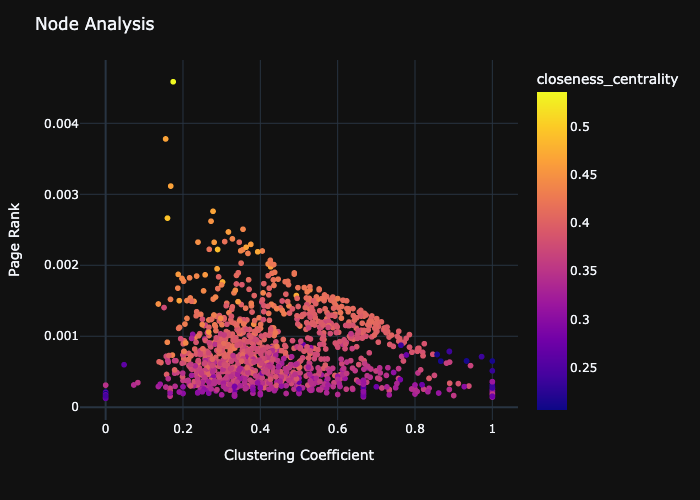

In [41]:
# Setting the default theme to 'plotly_dark'
pio.templates.default = "plotly_dark"

# Assuming node_analysis is your DataFrame and it contains 'page_rank', 'closeness_centrality', and 'username' columns
fig = px.scatter(node_analysis.query('closeness_centrality > 0.2'), x='clustering_coefficient', y='page_rank', color='closeness_centrality', hover_data=['username'])



# Update layout if needed
fig.update_layout(title='Node Analysis',
                  xaxis_title='Clustering Coefficient',
                  yaxis_title='Page Rank',
                  hovermode='closest')


# # Show the plot
fig.show()

Although PageRank is important, a high ratio of PageRank to degree is a very strong indicator that someone is close, particularly when their degree is high (above at least 75):

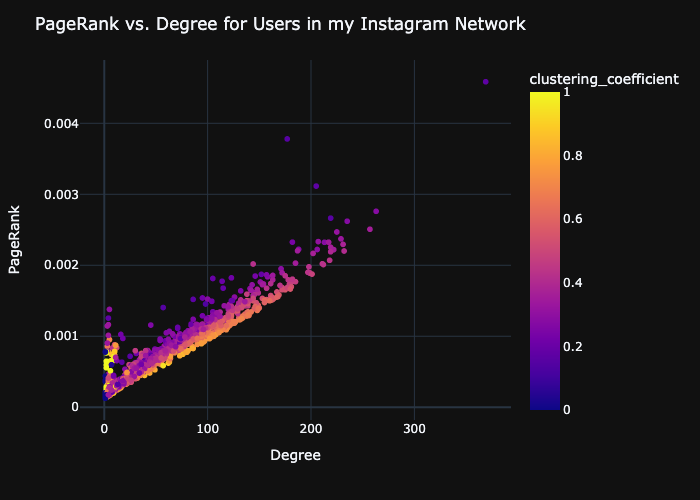

In [42]:
# Assuming node_analysis is your DataFrame and it contains 'page_rank', 'closeness_centrality', and 'username' columns
fig = px.scatter(node_analysis, x='degree', y='page_rank', color='clustering_coefficient', hover_data=['username'])

# Update layout if needed
fig.update_layout(title='PageRank vs. Degree for Users in my Instagram Network',
                  xaxis_title='Degree',
                  yaxis_title='PageRank',
                  hovermode='closest')

# Show the plot
fig.show()

The following table might not mean much to you, since I've switched out the names for generic usernames, but many of these users are among my closest friends. There are a handful of people that are high on this list even though I'm not particularly close to them, and from what I can tell these people are well-connected within two or more subcommunities. For example, maybe they were a year behind at a high school that I had friends at in Saint Louis, and were also in the same club as me at USC.

In [43]:
node_analysis['page_rank / degree'] = node_analysis['page_rank'] / node_analysis['degree']
node_analysis.query('degree > 75').sort_values(by='page_rank / degree', ascending=False).head(15)

,username,page_rank,clustering_coefficient,degree,closeness_centrality,betweenness_centrality,eigenvector_centrality,degree_centrality,page_rank_rank,clustering_coefficient_rank,closeness_centrality_rank,betweenness_centrality_rank,eigenvector_centrality_rank,degree_centrality_rank,page_rank / degree
100,UrbanUdon,0.003780,0.155110,177,0.466083,0.039732,0.026618,0.137958,0.999221,0.059969,0.992991,0.998442,0.838785,0.970794,0.000021
650,BoleroBrisket,0.001519,0.167715,86,0.429108,0.014508,0.004073,0.067030,0.932243,0.072430,0.950156,0.989097,0.619159,0.737928,0.000018
637,UrbaneUsher,0.001814,0.197436,105,0.440654,0.022031,0.003534,0.081839,0.968069,0.085670,0.978193,0.995327,0.599688,0.811916,0.000017
1,MotifMonarch,0.001540,0.219037,95,0.431148,0.006406,0.019554,0.074045,0.938474,0.109034,0.958723,0.968847,0.803738,0.772586,0.000016
46,CityLights,0.001775,0.201677,114,0.432889,0.007334,0.022857,0.088854,0.964953,0.093458,0.964174,0.972741,0.821651,0.847741,0.000016
83,GrailGuard,0.001524,0.277980,100,0.428485,0.003174,0.017110,0.077942,0.933022,0.206386,0.948598,0.939252,0.784268,0.789330,0.000015
145,PatchPundit,0.003116,0.168245,205,0.464980,0.021310,0.037125,0.159782,0.998442,0.073209,0.992212,0.993769,0.870717,0.985202,0.000015
676,KnotsmanKnight,0.001454,0.136335,98,0.448191,0.017629,0.009391,0.076383,0.914330,0.055296,0.983645,0.992212,0.704829,0.780374,0.000015
131,GingerGala,0.001823,0.216980,123,0.434004,0.004680,0.021767,0.095869,0.968847,0.107477,0.966511,0.958723,0.816978,0.880062,0.000015
55,LegendLiege,0.001678,0.186728,115,0.434324,0.007911,0.021992,0.089634,0.954829,0.080218,0.968458,0.974299,0.818536,0.850857,0.000015


### Next Steps
##### Enhancing Recursive Balanced Louvain Algorithm
A disadvantage of the Recursive Balanced Louvain algorithm is that in order to determine the splits to get from a graph to the original Louvain-determined partitions, it needs to consider every possible combination of supergroups of partitions, which has a time complexity of $O(2^N)$. Most of the time, there's only a handful of partitions and this number is manageable, but it's a serious performance issue if there's 20+ original partitions, which is not uncommon. To get around this, I included a `partition_size_threshold` parameter. Whenever the number of partitions is greater than this parameter, the algorithm creates a supergraph of the communities by turning each community into a node, and then performs a spectral bisection on supergraph. In the future, I'd like to implement a more elegant solution that is more aligned with the modularity-maximizing spirit of Louvain's algorithm, especially given the problems that we've identified earlier with spectral bisection.
##### Incorporating Other Data into Node Analysis
I looked at some common node metrics such as degree, closeness centrality, clustering coefficient, and PageRank to try to find determinants of what makes a close friend, but this analysis could be enriched by the other data sources at my disposal:
- **Date Added**: In the `following.json` file provided by Instagram, they provide the date that you followed each user on Instagram. One problem with our analysis is that someone might be very well-connected in my network, but I added them through association with other people that I'm closer with. By looking at the proportion of mutual followers that I connected with before vs. after someone, I could get a good idea if a user is someone that I was actively forging connections with, which would point toward being a closer friend, vs. someone I met through my friends and might not necessarily be close with.
- **Follower/Following Count**: Another problem with the analysis is that family members and friends that aren't very Instagram savvy get drowned out by the digital socialites. One solution to this is to consider the proportion of mutual connections to their total number of connections.
- **Make this a Supervised Learning Problem with iMessage Data**: To make this into a supervised learning problem, I could mine my iMessage data and use a metric like total number of messages sent as a proxy for closeness. Then I could build a predictive algorithm using the node metrics and use a technique like SHAP to identify the most important features. One potential problem with this approach is that I would have much less text conversations than Instagram followers, and even then only a handful of people account for most of the text messages, so there may not be enough data points to build an effective predictive model.

### Parting Words
Everyone should be curious about their life, and data science is a great way to pursue that curiosity. A wise man once said that life is the people in it, and working with data related to those people, data that has such a personal significance to me, has been a real joy. There may not be many datasets out there that I have a greater domain knowledge of, and this was critical in quickly identifying data inconsistencies deriving interesting insights. I would encourage anyone with some level of technical ability and a curiosity to understand the communities that they are a part of to conduct this analysis with their own network. Data science doesn't have to exist purely for business intelligence or academic research, it's a tool that we can use to gain a deeper understanding of our own lives if we take the time to collect the right data and ask the right questions.